## Exercise-6
Wenfeng Zhu-Computer Vision and Deep Learning: Visual Synthesis

Import the necessary libraries:

In [3]:
import numpy as np
import os
import torch
import torchvision.models
from torch.optim import Adam
import copy
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from torch.autograd import Variable

use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
# Select device to work on.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Task 1: Filters Visualization

1. VGG16. As the first task you need to load the pretrained VGG16 network. Please familiarize yourself with the network architecture and print short model description.
2. Optimize input image. You have learned in the lecture that the learning of neural network is performed by means of gradient descent on the network weights with the objective to minimize the loss function on the input batch of images. This process can be actually turned around: we can change the input image values in order to maximize output activation. Familiarize yourself with the code in file filters_visualization.py. Print the values for all the output tensors obtained from all layers in a loop over model layers.

In [4]:
def load_vgg16():
    vgg16 = torchvision.models.vgg16(pretrained=True).features.to(device)
    for index, layer in enumerate(vgg16):
        print(layer)


load_vgg16()

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

3. Visualize random filter. Now we can actually apply the optimization process to the input image pixels to maximize activations of the selected filter in the selected layer. Run this process multiple times for different filters filter_nmbr and visualize activations. Your results should look similar to Fig.3.

C:\Users\ZhuWe\AppData\Local\Temp/ipykernel_14148/1947663986.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(processed_image, device=device).float()


Step 00001. Loss:1.63
Step 00002. Loss:1.00
Step 00003. Loss:-1.68
Step 00004. Loss:-4.89
Step 00005. Loss:-9.01
Step 00006. Loss:-12.98
Step 00007. Loss:-17.40
Step 00008. Loss:-21.85
Step 00009. Loss:-26.41
Step 00010. Loss:-31.11
Step 00011. Loss:-35.82
Step 00012. Loss:-40.58
Step 00013. Loss:-45.40
Step 00014. Loss:-50.22
Step 00015. Loss:-55.04
Step 00016. Loss:-59.92
Step 00017. Loss:-64.76
Step 00018. Loss:-69.64
Step 00019. Loss:-74.54
Step 00020. Loss:-79.47
Step 00021. Loss:-84.42
Step 00022. Loss:-89.53
Step 00023. Loss:-94.66
Step 00024. Loss:-99.95
Step 00025. Loss:-105.23


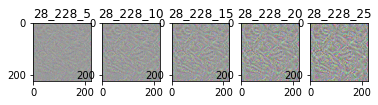

In [7]:
def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr * 255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1 / 0.229, 1 / 0.224, 1 / 0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def visualise_layer_filter(model, layer_nmbr, filter_nmbr, num_optim_steps=26):
    # Generate a random image
    rand_img = np.uint8(np.random.uniform(low=120,
                                          high=190,
                                          size=(224, 224, 3)))

    # Process image and return variable
    processed_image = preprocess_image(rand_img, False)
    processed_image = torch.tensor(processed_image, device=device).float()
    processed_image.requires_grad = True
    # Define optimizer for the image
    optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-5)
    for i in range(1, num_optim_steps):
        optimizer.zero_grad()
        # Assign create image to a variable to move forward in the model
        x = processed_image
        for index, layer in enumerate(model):
            # Forward pass layer by layer
            x = layer(x)
            if index == layer_nmbr: break

        conv_output = x[0, filter_nmbr]
        # Loss function is the mean of the output of the selected layer/filter
        # We try to minimize the mean of the output of that specific filter

        loss = -torch.mean(conv_output)

        # You may need to add total variation loss later
        # loss_tv = total_variation_loss(processed_image, 500.)
        # loss = -torch.mean(conv_output) + loss_tv*1.

        print(f'Step {i:05d}. Loss:{loss.data.cpu().numpy():0.2f}')
        # Compute gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
        # Recreate image

        # Save image
        if i % 5 == 0:
            optimized_image = recreate_image(processed_image.cpu())
            im_path = './output_filters_visualization/img' + str(layer_nmbr) + '_f' + str(filter_nmbr) + '_iter' + str(
                i) + '.jpg'
            save_image(optimized_image, im_path)
            plt.subplot(1, 5, int(i / 5))
            plt.imshow(optimized_image)
            plt.title(str(layer_nmbr) + '_' + str(filter_nmbr) + '_' + str(i))
    plt.show()


model = torchvision.models.vgg16(pretrained=True).features
model.eval()
# Fix model weights
for param in model.parameters():
    param.requires_grad = False
# Enable GPU
if use_gpu:
    model.cuda()

# Create the folder to export images if not exists
if not os.path.exists('./output_filters_visualization'):
    os.makedirs('./output_filters_visualization')

visualise_layer_filter(model, 28, 228)


4. Visualize filters at different levels. Now repeat the process for for different filters filter_nmbr and different layers layer_nmbr. Plot those activations. What do you observe going from earlier layers to later layers?

C:\Users\ZhuWe\AppData\Local\Temp/ipykernel_14148/1947663986.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(processed_image, device=device).float()


Step 00001. Loss:-0.12
Step 00002. Loss:-1.51
Step 00003. Loss:-3.96
Step 00004. Loss:-7.19
Step 00005. Loss:-10.97
Step 00006. Loss:-15.17
Step 00007. Loss:-19.63
Step 00008. Loss:-24.22
Step 00009. Loss:-28.83
Step 00010. Loss:-33.41
Step 00011. Loss:-37.96
Step 00012. Loss:-42.45
Step 00013. Loss:-46.84
Step 00014. Loss:-51.16
Step 00015. Loss:-55.39
Step 00016. Loss:-59.56
Step 00017. Loss:-63.71
Step 00018. Loss:-67.81
Step 00019. Loss:-71.90
Step 00020. Loss:-75.99
Step 00021. Loss:-80.07
Step 00022. Loss:-84.16
Step 00023. Loss:-88.24
Step 00024. Loss:-92.33
Step 00025. Loss:-96.45


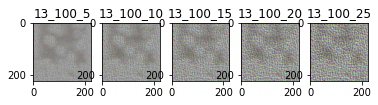

Step 00001. Loss:0.48
Step 00002. Loss:-1.15
Step 00003. Loss:-2.22
Step 00004. Loss:-3.08
Step 00005. Loss:-3.86
Step 00006. Loss:-4.60
Step 00007. Loss:-5.30
Step 00008. Loss:-5.98
Step 00009. Loss:-6.65
Step 00010. Loss:-7.30
Step 00011. Loss:-7.95
Step 00012. Loss:-8.59
Step 00013. Loss:-9.24
Step 00014. Loss:-9.88
Step 00015. Loss:-10.52
Step 00016. Loss:-11.16
Step 00017. Loss:-11.80
Step 00018. Loss:-12.43
Step 00019. Loss:-13.07
Step 00020. Loss:-13.71
Step 00021. Loss:-14.36
Step 00022. Loss:-15.00
Step 00023. Loss:-15.64
Step 00024. Loss:-16.28
Step 00025. Loss:-16.93


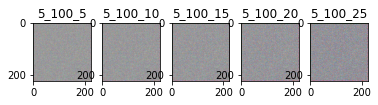

Step 00001. Loss:0.97
Step 00002. Loss:1.26
Step 00003. Loss:-0.76
Step 00004. Loss:-3.44
Step 00005. Loss:-7.49
Step 00006. Loss:-13.33
Step 00007. Loss:-20.62
Step 00008. Loss:-28.83
Step 00009. Loss:-37.85
Step 00010. Loss:-47.70
Step 00011. Loss:-58.75
Step 00012. Loss:-70.18
Step 00013. Loss:-81.80
Step 00014. Loss:-93.44
Step 00015. Loss:-105.46
Step 00016. Loss:-117.66
Step 00017. Loss:-130.02
Step 00018. Loss:-142.31
Step 00019. Loss:-154.78
Step 00020. Loss:-167.45
Step 00021. Loss:-180.15
Step 00022. Loss:-192.85
Step 00023. Loss:-205.95
Step 00024. Loss:-219.08
Step 00025. Loss:-232.36


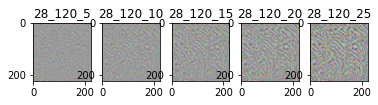

In [8]:
visualise_layer_filter(model, 13, 100)
visualise_layer_filter(model, 5, 100)
visualise_layer_filter(model, 28, 120)

The later the layer, the more features are extracted, the more features like edges, shapes, etc., but at the same time, the more abstract they become.

5. Hyperparameters tuning. The process of visualization is quite sensitive to the parameters. Some of the crucial parameters to tune are number of optimization steps num_optim_steps, learning rate lr and type of an optimizer optimizer. Vary those and describe what you see. Another important parameter is the input image rand_img initialization. Play with the low,high args used for initialization and desctibe what you see. In particular set them to the same value 125. What do you observe? Do you know a reason for that?

C:\Users\ZhuWe\AppData\Local\Temp/ipykernel_14148/3196148549.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(processed_image, device=device).float()


Step 00001. Loss:1.54
Step 00002. Loss:2.66
Step 00003. Loss:1.72
Step 00004. Loss:0.07
Step 00005. Loss:-1.38
Step 00006. Loss:-3.71
Step 00007. Loss:-6.05
Step 00008. Loss:-8.86
Step 00009. Loss:-11.95
Step 00010. Loss:-15.18
Step 00011. Loss:-18.64
Step 00012. Loss:-22.34
Step 00013. Loss:-26.04
Step 00014. Loss:-29.96
Step 00015. Loss:-33.99
Step 00016. Loss:-38.16
Step 00017. Loss:-42.33
Step 00018. Loss:-46.57
Step 00019. Loss:-50.79
Step 00020. Loss:-55.19
Step 00021. Loss:-59.78
Step 00022. Loss:-64.40
Step 00023. Loss:-69.08
Step 00024. Loss:-73.89
Step 00025. Loss:-78.79


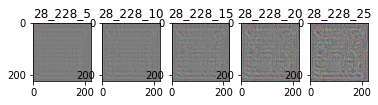

Step 00001. Loss:-0.19
Step 00002. Loss:-1.46
Step 00003. Loss:-3.35
Step 00004. Loss:-6.32
Step 00005. Loss:-8.35
Step 00006. Loss:-12.11
Step 00007. Loss:-15.12
Step 00008. Loss:-18.14
Step 00009. Loss:-21.16
Step 00010. Loss:-24.13
Step 00011. Loss:-27.09
Step 00012. Loss:-30.05
Step 00013. Loss:-32.98
Step 00014. Loss:-35.89
Step 00015. Loss:-38.80
Step 00016. Loss:-41.71
Step 00017. Loss:-44.63
Step 00018. Loss:-47.59
Step 00019. Loss:-50.57
Step 00020. Loss:-53.56
Step 00021. Loss:-56.58
Step 00022. Loss:-59.63
Step 00023. Loss:-62.70
Step 00024. Loss:-65.80
Step 00025. Loss:-68.94


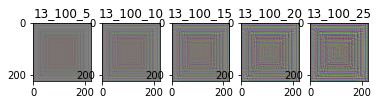

Step 00001. Loss:0.41
Step 00002. Loss:-0.16
Step 00003. Loss:-2.03
Step 00004. Loss:-3.17
Step 00005. Loss:-4.01
Step 00006. Loss:-4.80
Step 00007. Loss:-5.62
Step 00008. Loss:-6.45
Step 00009. Loss:-7.23
Step 00010. Loss:-8.00
Step 00011. Loss:-8.77
Step 00012. Loss:-9.54
Step 00013. Loss:-10.31
Step 00014. Loss:-11.08
Step 00015. Loss:-11.85
Step 00016. Loss:-12.63
Step 00017. Loss:-13.41
Step 00018. Loss:-14.19
Step 00019. Loss:-14.97
Step 00020. Loss:-15.75
Step 00021. Loss:-16.53
Step 00022. Loss:-17.33
Step 00023. Loss:-18.11
Step 00024. Loss:-18.90
Step 00025. Loss:-19.68


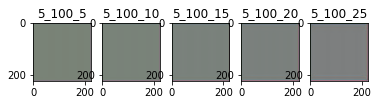

Step 00001. Loss:0.62
Step 00002. Loss:1.14
Step 00003. Loss:0.76
Step 00004. Loss:-0.66
Step 00005. Loss:-2.02
Step 00006. Loss:-4.26
Step 00007. Loss:-7.07
Step 00008. Loss:-10.70
Step 00009. Loss:-14.89
Step 00010. Loss:-20.18
Step 00011. Loss:-26.08
Step 00012. Loss:-32.64
Step 00013. Loss:-40.06
Step 00014. Loss:-47.98
Step 00015. Loss:-56.67
Step 00016. Loss:-66.01
Step 00017. Loss:-76.20
Step 00018. Loss:-86.88
Step 00019. Loss:-98.15
Step 00020. Loss:-109.40
Step 00021. Loss:-120.95
Step 00022. Loss:-132.39
Step 00023. Loss:-144.06
Step 00024. Loss:-155.86
Step 00025. Loss:-167.72


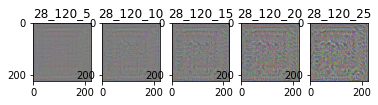

In [10]:
def visualise_layer_filter_change(model, layer_nmbr, filter_nmbr, num_optim_steps=26):
    # Generate a random image
    rand_img = np.uint8(np.random.uniform(low=125,
                                          high=125,
                                          size=(224, 224, 3)))

    # Process image and return variable
    processed_image = preprocess_image(rand_img, False)
    processed_image = torch.tensor(processed_image, device=device).float()
    processed_image.requires_grad = True
    # Define optimizer for the image
    optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-5)
    for i in range(1, num_optim_steps):
        optimizer.zero_grad()
        # Assign create image to a variable to move forward in the model
        x = processed_image
        for index, layer in enumerate(model):
            # Forward pass layer by layer
            x = layer(x)
            if index == layer_nmbr: break

        conv_output = x[0, filter_nmbr]
        # Loss function is the mean of the output of the selected layer/filter
        # We try to minimize the mean of the output of that specific filter

        loss = -torch.mean(conv_output)

        # You may need to add total variation loss later
        # loss_tv = total_variation_loss(processed_image, 500.)
        # loss = -torch.mean(conv_output) + loss_tv*1.

        print(f'Step {i:05d}. Loss:{loss.data.cpu().numpy():0.2f}')
        # Compute gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
        # Recreate image

        # Save image
        if i % 5 == 0:
            optimized_image = recreate_image(processed_image.cpu())
            im_path = './output_filters_visualization/img' + str(layer_nmbr) + '_f' + str(filter_nmbr) + '_iter' + str(
                i) + '.jpg'
            save_image(optimized_image, im_path)
            plt.subplot(1, 5, int(i / 5))
            plt.imshow(optimized_image)
            plt.title(str(layer_nmbr) + '_' + str(filter_nmbr) + '_' + str(i))
    plt.show()


visualise_layer_filter_change(model, 28, 228)
visualise_layer_filter_change(model, 13, 100)
visualise_layer_filter_change(model, 5, 100)
visualise_layer_filter_change(model, 28, 120)

A higher number of iterations of optimization will make the visual features more visible, but has the potential to cause fitting. And when the upper and lower limits of the random images are set to be the same, the extracted feature maps show regularity, which is because the images are already solid colors and the pixels are uniformly distributed.

6. Pretrained weights. The filters’ visualizations you observe are a result of a long and computationally expensive training of the VGG16 network on the millions of images. You can try to visualize the filters without having pretrained weights: change pretrained to False. What do you observe?

C:\Users\ZhuWe\AppData\Local\Temp/ipykernel_14148/1947663986.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  processed_image = torch.tensor(processed_image, device=device).float()


Step 00001. Loss:0.04
Step 00002. Loss:0.01
Step 00003. Loss:-0.02
Step 00004. Loss:-0.04
Step 00005. Loss:-0.06
Step 00006. Loss:-0.08
Step 00007. Loss:-0.09
Step 00008. Loss:-0.10
Step 00009. Loss:-0.12
Step 00010. Loss:-0.13
Step 00011. Loss:-0.13
Step 00012. Loss:-0.14
Step 00013. Loss:-0.15
Step 00014. Loss:-0.16
Step 00015. Loss:-0.16
Step 00016. Loss:-0.17
Step 00017. Loss:-0.18
Step 00018. Loss:-0.18
Step 00019. Loss:-0.19
Step 00020. Loss:-0.20
Step 00021. Loss:-0.20
Step 00022. Loss:-0.21
Step 00023. Loss:-0.21
Step 00024. Loss:-0.22
Step 00025. Loss:-0.22


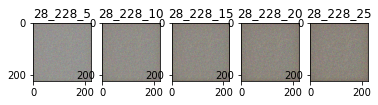

Step 00001. Loss:-0.02
Step 00002. Loss:-0.05
Step 00003. Loss:-0.06
Step 00004. Loss:-0.07
Step 00005. Loss:-0.08
Step 00006. Loss:-0.08
Step 00007. Loss:-0.08
Step 00008. Loss:-0.08
Step 00009. Loss:-0.08
Step 00010. Loss:-0.08
Step 00011. Loss:-0.08
Step 00012. Loss:-0.08
Step 00013. Loss:-0.08
Step 00014. Loss:-0.08
Step 00015. Loss:-0.08
Step 00016. Loss:-0.08
Step 00017. Loss:-0.08
Step 00018. Loss:-0.09
Step 00019. Loss:-0.09
Step 00020. Loss:-0.10
Step 00021. Loss:-0.10
Step 00022. Loss:-0.11
Step 00023. Loss:-0.12
Step 00024. Loss:-0.12
Step 00025. Loss:-0.13


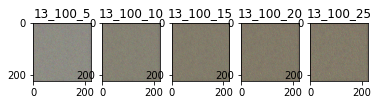

Step 00001. Loss:-0.01
Step 00002. Loss:-0.03
Step 00003. Loss:-0.04
Step 00004. Loss:-0.05
Step 00005. Loss:-0.05
Step 00006. Loss:-0.06
Step 00007. Loss:-0.06
Step 00008. Loss:-0.06
Step 00009. Loss:-0.07
Step 00010. Loss:-0.07
Step 00011. Loss:-0.08
Step 00012. Loss:-0.09
Step 00013. Loss:-0.10
Step 00014. Loss:-0.11
Step 00015. Loss:-0.12
Step 00016. Loss:-0.13
Step 00017. Loss:-0.15
Step 00018. Loss:-0.16
Step 00019. Loss:-0.18
Step 00020. Loss:-0.19
Step 00021. Loss:-0.20
Step 00022. Loss:-0.22
Step 00023. Loss:-0.23
Step 00024. Loss:-0.24
Step 00025. Loss:-0.25


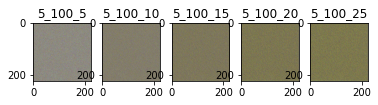

Step 00001. Loss:0.03
Step 00002. Loss:-0.00
Step 00003. Loss:-0.03
Step 00004. Loss:-0.05
Step 00005. Loss:-0.07
Step 00006. Loss:-0.09
Step 00007. Loss:-0.11
Step 00008. Loss:-0.12
Step 00009. Loss:-0.13
Step 00010. Loss:-0.14
Step 00011. Loss:-0.15
Step 00012. Loss:-0.16
Step 00013. Loss:-0.17
Step 00014. Loss:-0.17
Step 00015. Loss:-0.18
Step 00016. Loss:-0.19
Step 00017. Loss:-0.19
Step 00018. Loss:-0.20
Step 00019. Loss:-0.20
Step 00020. Loss:-0.21
Step 00021. Loss:-0.21
Step 00022. Loss:-0.22
Step 00023. Loss:-0.22
Step 00024. Loss:-0.23
Step 00025. Loss:-0.23


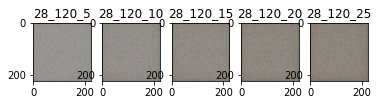

In [12]:
model = torchvision.models.vgg16(pretrained=False).features.to(device)
model.eval()

visualise_layer_filter(model, 28, 228)
visualise_layer_filter(model, 13, 100)
visualise_layer_filter(model, 5, 100)
visualise_layer_filter(model, 28, 120)

The values obtained from the loss are small and change slowly, and the resulting feature maps are basically meaningless because the weight matrix of the non-pre-trained model has only uninitialized values that do not help the fast convergence when extracting features.